<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Давайте-посмоотрим-на-данные" data-toc-modified-id="Давайте-посмоотрим-на-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Давайте посмоотрим на данные</a></span><ul class="toc-item"><li><span><a href="#Загружаем-данные" data-toc-modified-id="Загружаем-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загружаем данные</a></span></li><li><span><a href="#Модифицируем-данные" data-toc-modified-id="Модифицируем-данные-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Модифицируем данные</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random

In [2]:
DATA_PATH = './data/Accel_data/data_raw.txt'

## Давайте посмоотрим на данные
### Загружаем данные

In [3]:
dictionary = {'user':[], 'activity':[], 'time':[], 'x_acc':[],'y_acc':[],'z_acc':[] }

def parse_line( line):
    user = activity = time = x_acc = y_acc = z_acc = None
    try:
        string = line.strip(';\n').split(',')
        user = int( string[ 0 ])
        activity = string[ 1 ]
        time = int( string[ 2 ])
        x_acc = float( string[ 3 ])
        y_acc = float( string[ 4 ])
        z_acc = float( string[ 5 ])
    except:
        print( 'dropped', line)
    else:
        if time and time > 1e-9:
            dictionary['user'].append(user)
            dictionary['activity'].append( activity)
            dictionary['time'].append( time)
            dictionary['x_acc'].append( x_acc)
            dictionary['y_acc'].append( y_acc)
            dictionary['z_acc'].append( z_acc)

with open (DATA_PATH, "r") as file:
    for line in file.readlines():
        for sline in line.split(';'):
            if sline.strip():
                parse_line( sline)
row_data = pd.DataFrame(data = dictionary)
row_data = row_data.sort_values(by = ['user', 'time'])

row_data.head(10)

dropped 11,Walking,1867172313000,4.4,4.4,



,user,activity,time,x_acc,y_acc,z_acc
929120,1,Walking,4991922345000,0.69,10.80,-2.03
929121,1,Walking,4991972333000,6.85,7.44,-0.50
929122,1,Walking,4992022351000,0.93,5.63,-0.50
929123,1,Walking,4992072339000,-2.11,5.01,-0.69
929124,1,Walking,4992122358000,-4.59,4.29,-1.95
929125,1,Walking,4992172376000,12.41,11.18,7.82
929126,1,Walking,4992222333000,17.27,11.60,5.94
929127,1,Walking,4992272321000,1.42,8.43,-5.28
929128,1,Walking,4992322339000,-2.68,15.89,-0.38
929129,1,Walking,4992372327000,-1.38,9.92,-1.99


In [4]:
print( row_data.size//len(row_data.columns))
users = set(row_data.user)
activities = set(row_data.activity)
print(users)
print(activities)

1085363
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}
{'Downstairs', 'Walking', 'Upstairs', 'Jogging', 'Sitting', 'Standing'}


# [21]


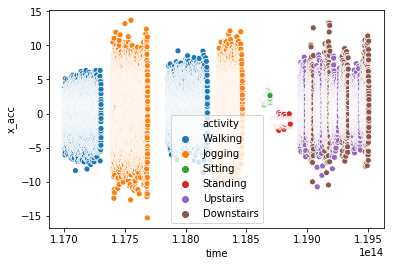

In [5]:
user = random.sample(users, 1)
sns.scatterplot(x="time", y="x_acc", hue="activity",data=row_data[row_data.user == user])
print('#', user)
plt.show()

### Модифицируем данные
Номер пользователя является избыточной информацией, вместо нее введем номер трека, для каждого типа движения


In [6]:
row_cols = ['user', 'activity', 'time', 'x_acc','y_acc','z_acc']
cols = ['track', 'activity', 'time', 'x_acc', 'y_acc', 'z_acc', 'avx_acc', 'avy_acc', 'avz_acc', 'g2']

user = -1
activity = None
track = 0
startpoint = 0
last = None
data_dict = {key:[] for key in cols}
traks_by_type = {key:[] for key in activities}
i = 0 # index inside track
next_track = False
NUM_OF_SAMPLES = 100 # numper of samples for average 5 seconds in real time

ax_arr = []
ay_arr = []
az_arr = []

for row in row_data.values:
    delta = row[2] - last if ( last is not None) else None
    if user != row[0] or activity != row[1] or (delta and delta > 0.25*10**9):
        if next_track:
            track += 1
        activity = row[1]
        user = row[0]
        startpoint = row[2]
        last = None
        traks_by_type[activity].append(track)
        i = 0
        next_track = False
    if i > NUM_OF_SAMPLES:
        next_track = True
        data_dict['track'].append(track)
        data_dict['activity'].append(activity)
        data_dict['time'].append((row[2] - startpoint)/1e9)
        data_dict['x_acc'].append(row[3])
        data_dict['y_acc'].append(row[4])
        data_dict['z_acc'].append(row[5])
        ax = np.average(ax_arr[-NUM_OF_SAMPLES:])
        ay = np.average(ay_arr[-NUM_OF_SAMPLES:])
        az = np.average(az_arr[-NUM_OF_SAMPLES:])
        data_dict['avx_acc'].append(ax)
        data_dict['avy_acc'].append(ay)
        data_dict['avz_acc'].append(az)
        data_dict['g2'].append(ax**2 + ay**2 + az**2)
    last = row[2]
    ax_arr.append(row[3])
    ay_arr.append(row[4])
    az_arr.append(row[5])
    i += 1
data = pd.DataFrame(data=data_dict)

data.head(10)

,track,activity,time,x_acc,y_acc,z_acc,avx_acc,avy_acc,avz_acc,g2
0,0,Walking,5.069977,12.57,10.65,3.87,3.7657,9.8097,-0.4454,110.609092
1,0,Walking,5.119965,6.74,15.51,-0.38,3.8229,9.8418,-0.4017,111.636955
2,0,Walking,5.169953,2.91,19.50,-4.63,3.8810,9.9406,-0.4005,114.038090
3,0,Walking,5.220002,-0.11,15.02,-5.94,3.9312,10.0855,-0.4399,117.365156
4,0,Walking,5.269989,4.67,5.18,-0.76,3.9760,10.1928,-0.4798,119.931956
5,0,Walking,5.319977,0.57,3.53,-1.33,3.8986,10.1328,-0.5656,118.192621
6,0,Walking,5.369996,-2.83,2.79,-3.02,3.7316,10.0521,-0.6383,115.376980
7,0,Walking,5.419953,-9.58,5.13,-4.25,3.6891,9.9957,-0.6157,113.902564
8,0,Walking,5.470002,9.04,9.77,12.11,3.6201,9.8881,-0.6544,111.307885
9,0,Walking,5.519989,19.04,16.02,3.11,3.7243,9.8866,-0.5134,111.878850


In [7]:
num_tacks = track
for key, value in traks_by_type.items():
    print('%s: %i'%(key, len(value)))

Downstairs: 193
Walking: 255
Upstairs: 178
Jogging: 1779
Sitting: 28
Standing: 25


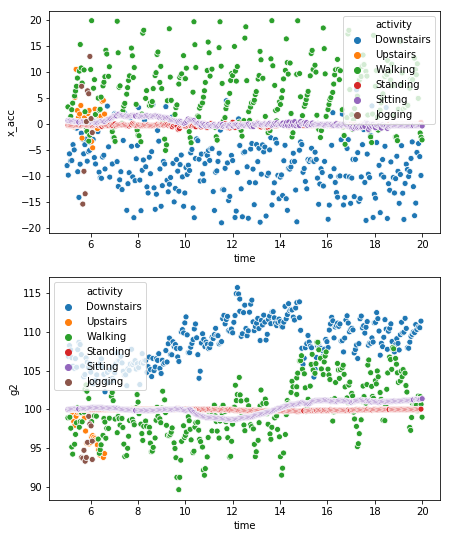

In [8]:
tr_ids = [random.choice(x) for x in  traks_by_type.values()]

f, axes = plt.subplots(2, 1, figsize=(7, 9))

sns.scatterplot(x="time", y="x_acc", hue="activity",
                data=data[data.track.apply(lambda v: v in tr_ids) & (data.time < 20)],
                ax=axes[0])

sns.scatterplot(x="time", y="g2", hue="activity",
                data=data[data.track.apply(lambda v: v in tr_ids) & (data.time < 20)],
                ax=axes[1])

plt.show()

В описании датасета сказано, что данныйе включают ускорение, земного притяжения равное 10, поэтому перейдем к призноковуму описанию: ускорение к "центру земли| перпенддикулярное ускорение 

In [9]:
data['vert_acc'] = (data.avx_acc * data.x_acc + data.avy_acc * data.y_acc + data.avz_acc * data.z_acc) / data.g2 # (g a)/g^2
data['hor_acc'] = ((data.x_acc**2 + data.y_acc**2 + data.z_acc**2) / data.g2 - data.vert_acc**2)**0.5
data.head(10)

,track,activity,time,x_acc,y_acc,z_acc,avx_acc,avy_acc,avz_acc,g2,vert_acc,hor_acc
0,0,Walking,5.069977,12.57,10.65,3.87,3.7657,9.8097,-0.4454,110.609092,1.356891,0.864977
1,0,Walking,5.119965,6.74,15.51,-0.38,3.8229,9.8418,-0.4017,111.636955,1.599518,0.067834
2,0,Walking,5.169953,2.91,19.50,-4.63,3.8810,9.9406,-0.4005,114.038090,1.815093,0.549624
3,0,Walking,5.220002,-0.11,15.02,-5.94,3.9312,10.0855,-0.4399,117.365156,1.309288,0.713238
4,0,Walking,5.269989,4.67,5.18,-0.76,3.9760,10.1928,-0.4798,119.931956,0.598100,0.229493
5,0,Walking,5.319977,0.57,3.53,-1.33,3.8986,10.1328,-0.5656,118.192621,0.327797,0.125271
6,0,Walking,5.369996,-2.83,2.79,-3.02,3.7316,10.0521,-0.6383,115.376980,0.168254,0.433153
7,0,Walking,5.419953,-9.58,5.13,-4.25,3.6891,9.9957,-0.6157,113.902564,0.162886,1.081129
8,0,Walking,5.470002,9.04,9.77,12.11,3.6201,9.8881,-0.6544,111.307885,1.090737,1.311327
9,0,Walking,5.519989,19.04,16.02,3.11,3.7243,9.8866,-0.5134,111.878850,2.035213,1.215967


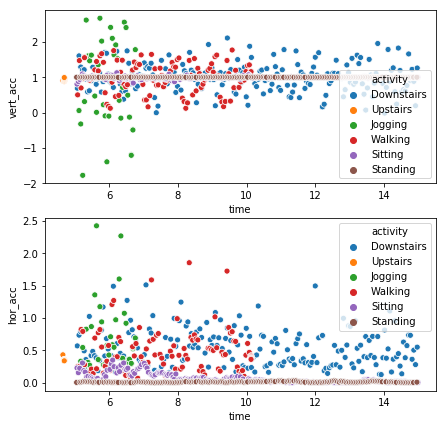

In [10]:
tr_ids = [random.choice(x) for x in  traks_by_type.values()]

f, axes = plt.subplots(2, 1, figsize=(7, 7))

sns.scatterplot(x="time", y="vert_acc", hue="activity",
                data=data[data.track.apply(lambda v: v in tr_ids) & (data.time < 15)],
                ax=axes[0])

sns.scatterplot(x="time", y="hor_acc", hue="activity",
                data=data[data.track.apply(lambda v: v in tr_ids) & (data.time < 15)],
                ax=axes[1])

plt.show()

Перейдем к более коротким трекам (10 секунд) - для увеличения числа обектов в выборке, а так же сменим также сменим признаковое описание трека - амплтуда, среднее, спектральные характеристики

In [11]:
data_short = data.drop(columns = ['x_acc','y_acc','z_acc', 'avx_acc', 'avy_acc', 'avz_acc', 'g2'])
new_columns = ['vert_acc_av', 'hor_acc_av', 'vert_acc_std', 'hor_acc_std', 'label']
new_data_dict = {key:[] for key in new_columns}
tracks_by_label = {key:[] for key in activities}
SEMP_NUM = 300 
ind = 0

for track in range(num_tacks):
    track_data = data_short[data_short.track == track].drop(columns=['track'])
    for i in range(len(track_data)//SEMP_NUM):
        new_data_dict['vert_acc_av'].append(track_data.vert_acc.mean())
        new_data_dict['vert_acc_std'].append(track_data.vert_acc.std())
        new_data_dict['hor_acc_av'].append(track_data.hor_acc.mean())
        new_data_dict['hor_acc_std'].append(track_data.hor_acc.std())
        new_data_dict['label'].append(track_data.activity.values[0])

new_data = pd.DataFrame(data = new_data_dict)

/home/anton/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


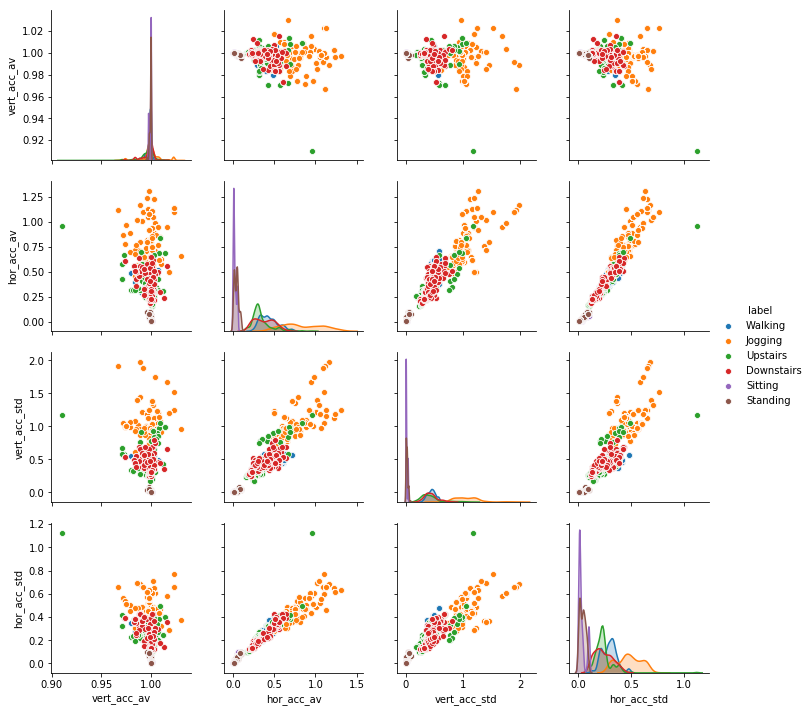

In [12]:
sns.pairplot(new_data, hue='label')

plt.show()